<a href="https://colab.research.google.com/github/dipta007/Movie-Recommendation/blob/development/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount the Google Drive

In [1]:
from google.colab import drive
from os.path import join
import os

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Colab_data/MR1'       # path to your project on Drive
drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)
!mkdir "{PROJECT_PATH}"    # in case we haven't created it already   
%cd "{PROJECT_PATH}"
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/Colab_data/MR1’: File exists
/content/drive/My Drive/Colab_data/MR1
data/  model  model-multi-label  multilayer_perceptron_graph.png


# Get the ratings

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

DATA_PATH = './data/ml-latest-small'

ratings = pd.read_csv(f"{DATA_PATH}/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Get all the movies and their mapping

In [3]:
movies = pd.read_csv(f"{DATA_PATH}/movies.csv")
movies_ind_to_name = dict(zip(movies.movieId, movies.title))
movies_name_to_ind = dict(zip(movies.title, movies.movieId))
movies_ind_to_genre = dict(zip(movies.movieId, movies.genres))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Get all the TMDB Links

In [0]:
links = pd.read_csv(f"{DATA_PATH}/links.csv")
links['tmdbId'] = links['tmdbId'].fillna(-1).astype(int)
movie_to_tmdb = dict(zip(links.movieId, links.tmdbId))

# Get MetaData

In [46]:
from ast import literal_eval

metadata = pd.read_csv(f"{DATA_PATH}/movies_metadata.csv")
metadata.head()

# features = ['overview', ]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


# Get all the Genres

In [0]:
maxLen = max(movies['genres'].apply(lambda x: len(x.split('|'))))

def make_all_same(x):
  now = x.split("|")
  while len(now) < maxLen:
    now.append("")
  return now

movies['genres_list'] = movies['genres'].apply(make_all_same)

In [12]:
s = set()
for v in movies['genres_list'].values:
  for g in v:
    s.add(g)

n_genres = len(s)
n_genres

21

In [16]:
ratings['tmdbId'] = ratings['movieId'].apply(lambda x: movie_to_tmdb[x])
ratings = ratings.drop(['timestamp'], axis=1)
ratings.head()

,userId,movieId,rating,tmdbId
0,1,1,4.0,862
1,1,3,4.0,15602
2,1,6,4.0,949
3,1,47,5.0,807
4,1,50,5.0,629


In [17]:
ratings = pd.merge(ratings, movies, "inner", "movieId")
ratings.head()

,userId,movieId,rating,tmdbId,title,genres,genres_list
0,1,1,4.0,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fanta..."
1,5,1,4.0,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fanta..."
2,7,1,4.5,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fanta..."
3,15,1,2.5,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fanta..."
4,17,1,4.5,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fanta..."


In [18]:
ratings = ratings.drop(['title', 'genres'], axis=1)
ratings.head()

,userId,movieId,rating,tmdbId,genres_list
0,1,1,4.0,862,"[Adventure, Animation, Children, Comedy, Fanta..."
1,5,1,4.0,862,"[Adventure, Animation, Children, Comedy, Fanta..."
2,7,1,4.5,862,"[Adventure, Animation, Children, Comedy, Fanta..."
3,15,1,2.5,862,"[Adventure, Animation, Children, Comedy, Fanta..."
4,17,1,4.5,862,"[Adventure, Animation, Children, Comedy, Fanta..."


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Encode the userId
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

# Encode the movie ids
movie_enc = LabelEncoder()
movie_enc.fit(movies['movieId'])
ratings['movie'] = movie_enc.transform(ratings['movieId'].values)
n_movies = movies['movieId'].nunique()

# encode genere list
genre_enc = LabelEncoder()
genre_enc.fit(list(s))
ratings['genres_list'] = ratings['genres_list'].apply(lambda x: genre_enc.transform(x))
ratings.head()

# get ratings info
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

ratings.head()

,userId,movieId,rating,tmdbId,genres_list,user,movie
0,1,1,4.0,862,"[3, 4, 5, 6, 10, 0, 0, 0, 0, 0]",0,0
1,5,1,4.0,862,"[3, 4, 5, 6, 10, 0, 0, 0, 0, 0]",4,0
2,7,1,4.5,862,"[3, 4, 5, 6, 10, 0, 0, 0, 0, 0]",6,0
3,15,1,2.5,862,"[3, 4, 5, 6, 10, 0, 0, 0, 0, 0]",14,0
4,17,1,4.5,862,"[3, 4, 5, 6, 10, 0, 0, 0, 0, 0]",16,0


In [21]:
n_users, n_movies, n_genres

(610, 9742, 21)

In [22]:
X1 = ratings[['user', 'movie']].values
X2 = np.array([list(val) for val in ratings['genres_list'].values])
X = np.concatenate((X1, X2), axis=1)
y = ratings['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 12), (10084, 12), (90752,), (10084,))

In [0]:
X_train_array = [X_train[:, 0], X_train[:, 1], X_train[:, 2:]]
X_test_array = [X_test[:, 0], X_test[:, 1], X_test[:, 2:]]

In [24]:
del X_train
del X_test
import gc
gc.collect()

0

In [0]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout, Activation, Lambda, LSTM, Flatten
from keras.layers import Concatenate, Dense, Dropout

def Model1(min_rating, max_rating):
    user = Input(shape=(1,))
    u = Embedding(n_users, 20)(user)
    u = Flatten()(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, 10, name="movies")(movie)
    m = Flatten()(m)

    genre = Input(shape=(10,))
    # g = Embedding(n_genres, 10)(genre)
    # g = Flatten()(g)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(128, kernel_initializer='he_normal', activation="relu")(x)

    x = Dense(10, kernel_initializer='he_normal', activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal', activation="sigmoid")(x)

    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    model = Model(inputs=[user, movie, genre], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
    return model

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 20)        12200       input_18[0][0]                   
__________________________________________________________________________________________________
movies (Embedding)              (None, 1, 10)        97420       input_19[0][0]                   
____________________________________________________________________________________________

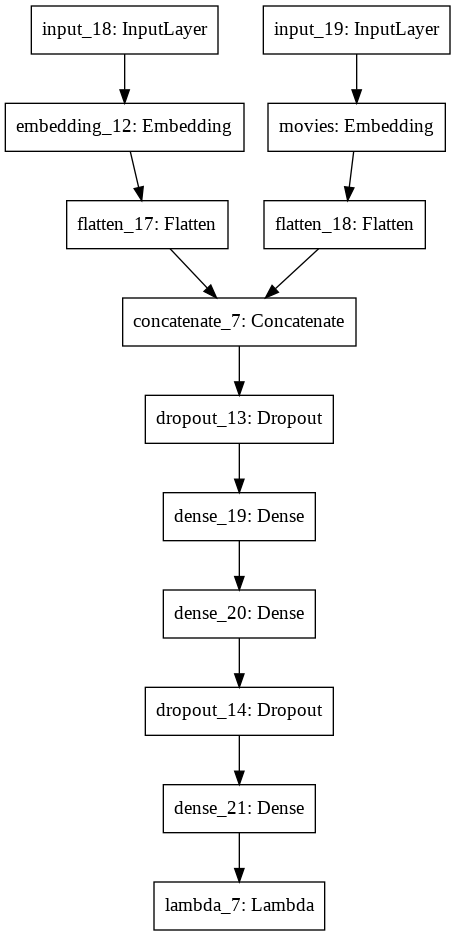

In [118]:
model = Model1(min_rating, max_rating)
model.summary()

from keras.utils import plot_model
plot_model(model, to_file='multilayer_perceptron_graph.png')

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

CHECKPOINT_PATH = './final-1'

callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss', patience=4))
callbacks.append(ModelCheckpoint(CHECKPOINT_PATH,  monitor='val_loss', save_best_only=True, save_weights_only=True))

In [0]:
# np.array(X_train_array).shape
# np.array(X_train_array[2]).shape
# X_train_array[2]
# X_train_array[2]

In [121]:
history = model.fit(x=X_train_array, y=y_train, batch_size=128, epochs=50,
                    verbose=1, validation_data=(X_test_array, y_test),
                    callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/50
90752/90752 [==============================] - 2s 25us/step - loss: 0.9819 - accuracy: 0.2678 - val_loss: 0.7619 - val_accuracy: 0.3053
Epoch 2/50
90752/90752 [==============================] - 2s 23us/step - loss: 0.8116 - accuracy: 0.3055 - val_loss: 0.7349 - val_accuracy: 0.3247
Epoch 3/50
90752/90752 [==============================] - 2s 23us/step - loss: 0.7691 - accuracy: 0.3179 - val_loss: 0.7291 - val_accuracy: 0.3308
Epoch 4/50
90752/90752 [==============================] - 2s 23us/step - loss: 0.7448 - accuracy: 0.3258 - val_loss: 0.7273 - val_accuracy: 0.3235
Epoch 5/50
90752/90752 [==============================] - 2s 23us/step - loss: 0.7104 - accuracy: 0.3322 - val_loss: 0.7309 - val_accuracy: 0.3276
Epoch 6/50
90752/90752 [==============================] - 2s 23us/step - loss: 0.6869 - accuracy: 0.3411 - val_loss: 0.7410 - val_accuracy: 0.3308
Epoch 7/50
90752/90752 [==============================] - 2s 23us/st

In [0]:
model.load_weights(CHECKPOINT_PATH)

In [123]:
model.layers[3].name

'movies'

In [0]:
mov2vec = model.layers[3].get_weights()[0]

In [125]:
mov2vec.shape

(9742, 10)

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(mov2vec, mov2vec)

In [127]:
sim.shape

(9742, 9742)

In [0]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, n = 10, cosine_sim=sim):
    # Get the index of the movie that matches the title
    org_id = movies_name_to_ind[title]
    print(org_id)
    enc_idx = movie_enc.transform([org_id])[0]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[enc_idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:n+1]

    # Get the movie indices
    enc_movie_indices = [i[0] for i in sim_scores]
    org_movie_indices = movie_enc.inverse_transform(enc_movie_indices)
    print(org_movie_indices)

    # Return the top 10 most similar movies
    return [movies_ind_to_name[movie] for movie in org_movie_indices]

In [130]:
get_recommendations("Inception (2010)")

79132
[ 2067  1212  3302   260  4262 27722  4226  4687  2083  1950]


['Doctor Zhivago (1965)',
 'Third Man, The (1949)',
 'Beautiful People (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Scarface (1983)',
 'Last Life in the Universe (Ruang rak noi nid mahasan) (2003)',
 'Memento (2000)',
 'Billy Liar (1963)',
 'Muppet Christmas Carol, The (1992)',
 'In the Heat of the Night (1967)']

In [129]:
get_recommendations("Notebook, The (2004)")

8533
[109723 137595 142550  56607   1962   1966 106889 145839     47 100556]


['Bag Man, The (2014)',
 'Magic Mike XXL (2015)',
 'Ryuzo and the Seven Henchmen (2015)',
 'Kite Runner, The (2007)',
 'Driving Miss Daisy (1989)',
 'Metropolitan (1990)',
 "Tim's Vermeer (2013)",
 'Concussion (2015)',
 'Seven (a.k.a. Se7en) (1995)',
 'Act of Killing, The (2012)']

In [84]:
from scipy.stats import pearsonr

pearson_sim = pearsonr(mov2vec, mov2vec)
pearson_sim.shape

TypeError: ignored